In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

5
contributors gave $
295793679.34000003
54
contributors gave $
12822032.69


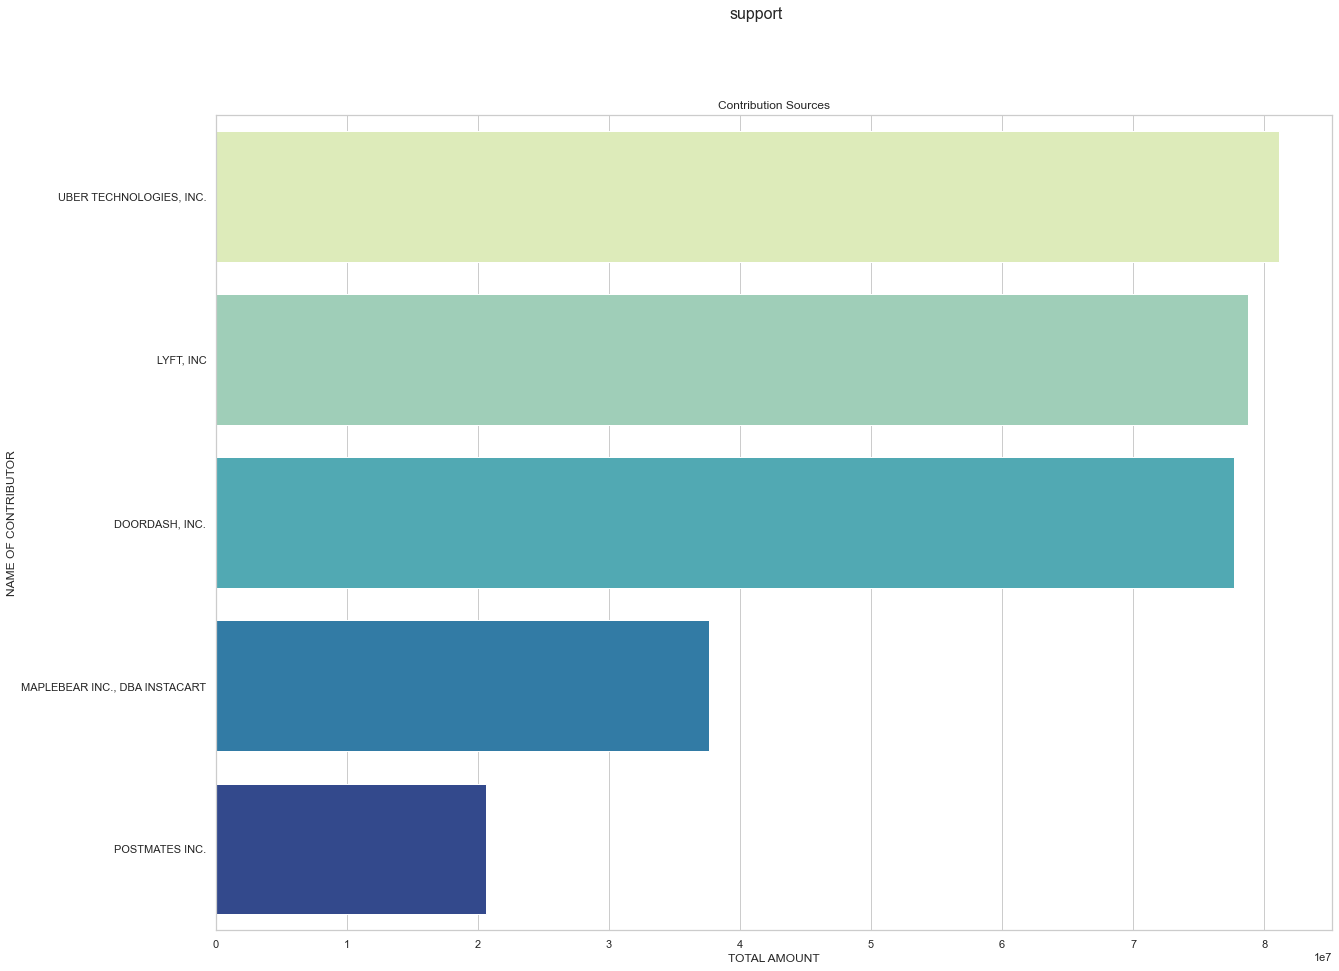

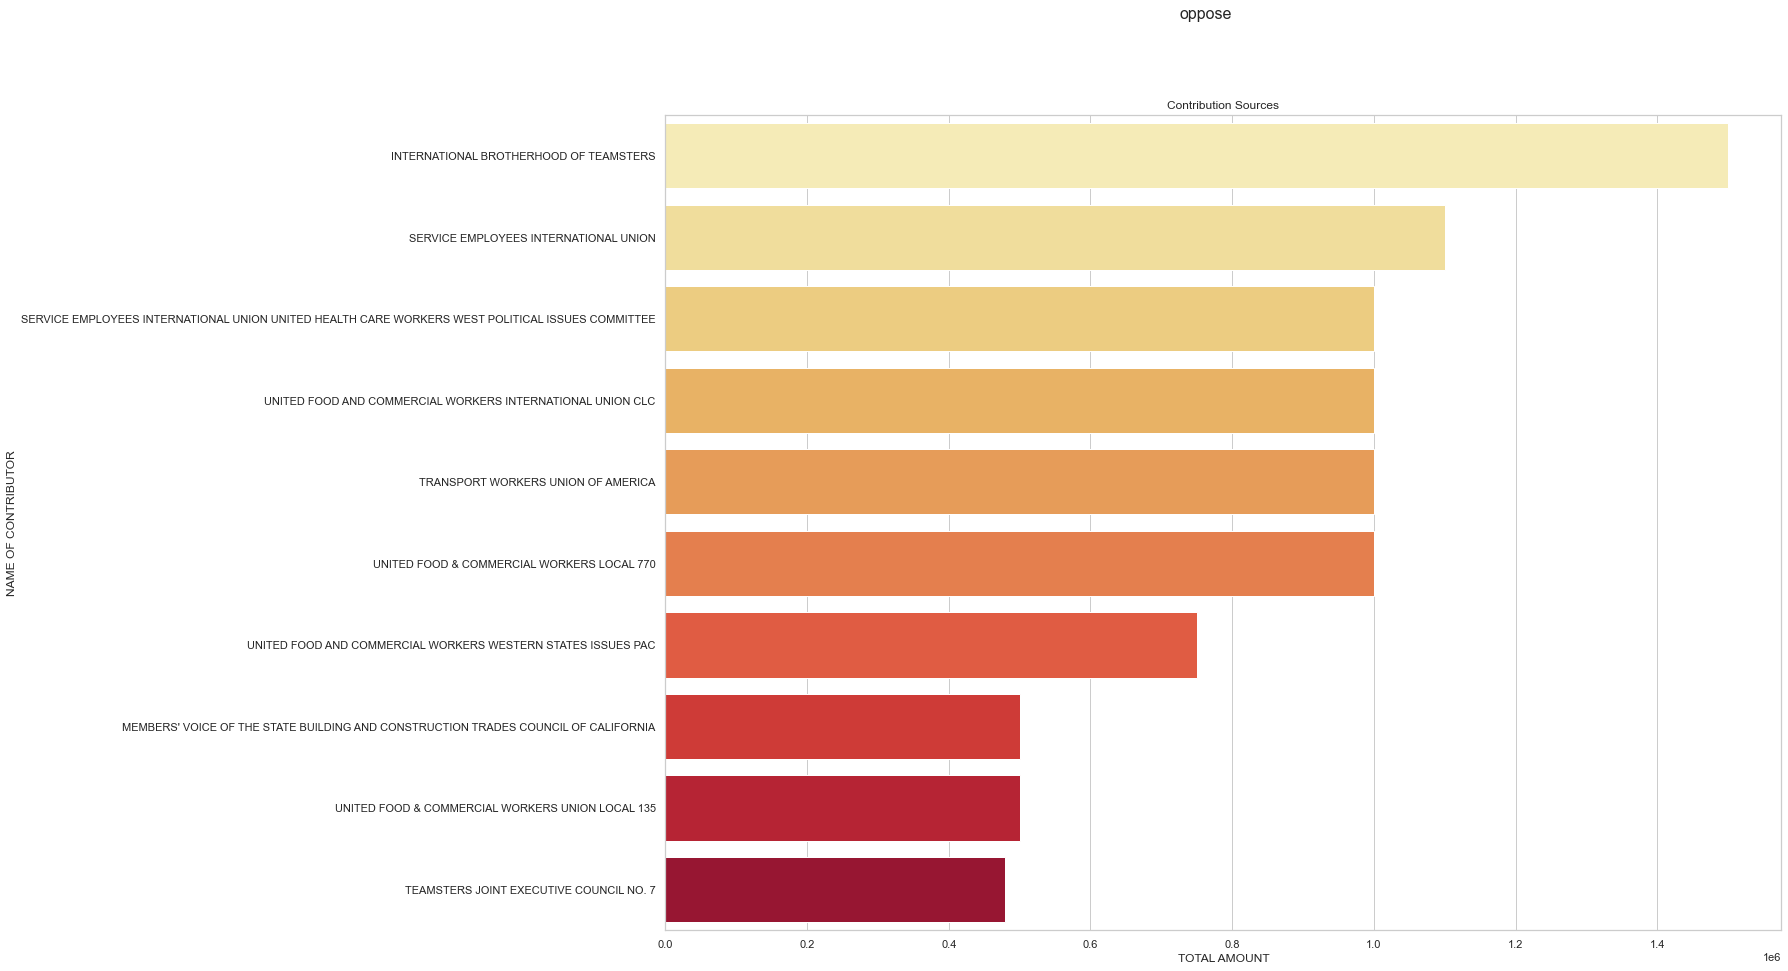

In [7]:
# this code extracts the monetary contributions made to the main supporting and opposing committees for prop 22
# and groups the data by contributor & date in the summary and groupedby_date tables and extracts the most frequent terms 
# from the no committe in the terms table
# summary, groupedby, and terms tables (5 tables total) are saved as csv files for the webpage to access

# coms stores the table of all committees for prop 22, topcoms stores the names of the folders of the main committees 
# committee contributions received files are read (both regular contributions and late contributions) and data is stored
# in dataset1,2 variables

path = 'cal-access-data/'+'committees.txt'
coms=pd.read_csv(path,delimiter="\t")
coms['NUMBER OF CONTRIBUTORS']= 0
coms['TOTAL CONTRIBUTIONS']=np.nan
coms['CONTRIBUTOR SUMMARY']= ""
coms['BY DATE']= ""
coms['BY TERMS']= ""
coms['NUMBER OF ENDORSERS']= 0
coms['ENDORSEMENT PHRASES']= ""
topcoms= ['1422181_SUPPORT/','1424537_OPPOSE/']
coals=['YesOnProp22.txt','NoOnProp22.txt']
colors=['YlGnBu','YlOrRd']

for i in range(len(topcoms)):
    com=topcoms[i]
    path = 'cal-access-data/'+ com
    file = path+'contributions_received.xls'
    dataset1=pd.read_csv(file,delimiter="\t")
    file = path+'/late_5000_contributions_received.xls'
    dataset2=pd.read_csv(file,delimiter="\t")

    # result dataframe stores concatenated dataset1,2 tables and removes duplicate transactions, if any, keeping the most recent
    # result stores the combined contributions a committee received
    df1= pd.DataFrame(dataset1, columns=['NAME OF CONTRIBUTOR','AMOUNT','TRANSACTION DATE', 'TRANSACTION NUMBER','FILED DATE'])
    df2= pd.DataFrame(dataset2,columns=['NAME OF CONTRIBUTOR','AMOUNT','TRANS. DATE', 'TRANS #','FILED DATE'])
    df2.rename(columns = {'TRANS. DATE':'TRANSACTION DATE','TRANS #':'TRANSACTION NUMBER'}, inplace = True)
    frames = [df1, df2]
    result = pd.concat(frames)
    result['TRANSACTION DATE']= pd.to_datetime(result['TRANSACTION DATE']) 
    result['FILED DATE']= pd.to_datetime(result['FILED DATE']) 
    result.AMOUNT=[x.replace(',','') for x in[x.strip('$') for x in[x.strip(' ') for x in result.AMOUNT]]]
    result['AMOUNT']= pd.to_numeric(result['AMOUNT']) 
    result.sort_values(by=['TRANSACTION NUMBER', 'FILED DATE'], inplace=True, ascending=True)
    result.drop_duplicates(subset=['TRANSACTION NUMBER'], keep='last')
    result.sort_values(by=['TRANSACTION DATE'], inplace=True, ascending=False)

    #summary dataframe aggregates the contributions made from each contributor, topten stores the 10 highest contributors
    summary= result.groupby(['NAME OF CONTRIBUTOR']).sum().reset_index()
    summary.rename(columns = {'AMOUNT':'TOTAL AMOUNT'}, inplace = True)
    summary.sort_values(by=['TOTAL AMOUNT'], inplace=True, ascending=False)
    summary.reset_index(drop=True, inplace=True)
    topten=summary.head(10)
    newpath='processed-data/'
    newfile=com[8:-1].lower()+'_cont_summary.csv'
    summary.to_csv(newpath+newfile)
    coms.loc[coms['COMMITTEE ID'] == int(com[:7]), 'CONTRIBUTOR SUMMARY'] = newfile
    
    #groupedby_date groups contributions by date
    groupedby_date = result.groupby('TRANSACTION DATE').sum().reset_index()
    groupedby_date['DAY'] = groupedby_date['TRANSACTION DATE'].dt.day
    groupedby_date['MONTH'] = groupedby_date['TRANSACTION DATE'].dt.month
    groupedby_date['YEAR'] = groupedby_date['TRANSACTION DATE'].dt.year
    newpath='processed-data/'
    newfile=com[8:-1].lower()+'_cont_bydate.csv'
    groupedby_date.to_csv(newpath+newfile)
    coms.loc[coms['COMMITTEE ID'] == int(com[:7]), 'BY DATE'] = newfile
    #plt.plot_date(x=groupedby_date['TRANSACTION DATE'], y=groupedby_date['AMOUNT'])
    
    #code to plot 10 highest contributors
    sns.set(style="whitegrid")
    source_data = topten
    plt.figure(figsize=(20,15))
    plt.subplot(title='Contribution Sources')
    sns.barplot(y='NAME OF CONTRIBUTOR',x='TOTAL AMOUNT', data=source_data, palette=colors[i]) 
    plt.suptitle(com[8:-1].lower(), fontsize=16)
    
    #updates committees table with number of contributors & total contributions from top yes & no campaigns
    count=summary["TOTAL AMOUNT"].count()
    coms.loc[coms['COMMITTEE ID'] == int(com[:7]), 'NUMBER OF CONTRIBUTORS'] = count
    coms.loc[coms['COMMITTEE ID'] == int(com[:7]), 'TOTAL CONTRIBUTIONS'] = result.AMOUNT.sum()
    
    #extracts the most common words from the no committee contributors
    if count > 40:
        cont={'CONTRIBUTOR':summary["NAME OF CONTRIBUTOR"].astype("string").str.cat(sep=' ').split()}
        terms = pd.DataFrame(cont)
        terms = pd.DataFrame(terms["CONTRIBUTOR"].value_counts())
        terms.drop(['OF','NO.','ON','THE','AND','&'], inplace = True)
        terms["PERCENT"]=terms["CONTRIBUTOR"]/count *100
        #terms=terms.head(10)
        newpath='processed-data/'
        newfile=com[8:-1].lower()+'_cont_byterms.csv'
        terms.to_csv(newpath+newfile)
        coms.loc[coms['COMMITTEE ID'] == int(com[:7]), 'BY TERMS'] = newfile
        
    print(summary["TOTAL AMOUNT"].count())
    print("contributors gave $")
    print(result.AMOUNT.sum())
    
    path = 'coalition-lists/'+coals[i]
    coal=pd.read_csv(path,delimiter="\t",header=None)
    coal.rename(columns = {0:'ENDORSERS'}, inplace = True)
    total=coal['ENDORSERS'].count()
    end={'COUNT':coal['ENDORSERS'].astype("string").str.cat(sep=' ').split()}
    coal = pd.DataFrame(end)
    coal = pd.DataFrame(coal["COUNT"].value_counts())
    coal.drop(['of','and'], inplace = True)
    coal.reset_index(inplace=True)
    coal.rename(columns = {'index':'WORD'}, inplace = True)
    coal['PERCENT']=coal["COUNT"]/total *100
    coms.loc[coms['COMMITTEE ID'] == int(com[:7]), 'NUMBER OF ENDORSERS'] = total
    newpath='processed-data/'
    newfile=com[8:-1].lower()+'_end_phrases.csv'
    groupedby_date.to_csv(newpath+newfile)
    coms.loc[coms['COMMITTEE ID'] == int(com[:7]), 'ENDORSEMENT PHRASES'] = newfile

coms.dropna(inplace=True)
coms.reset_index(inplace=True,drop=True)
coms
newpath='processed-data/'
newfile='guide.csv'
coms.to_csv(newpath+newfile)